<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Imports" data-toc-modified-id="Imports-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Imports</a></span></li><li><span><a href="#plot-NMI-as-beta-varies" data-toc-modified-id="plot-NMI-as-beta-varies-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>plot NMI as beta varies</a></span></li><li><span><a href="#elist=-randSBM.get_edgelist()" data-toc-modified-id="elist=-randSBM.get_edgelist()-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>elist= randSBM.get_edgelist()</a></span></li><li><span><a href="#hysteresis-in-modbp" data-toc-modified-id="hysteresis-in-modbp-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>hysteresis in modbp</a></span></li><li><span><a href="#Testing-on-football-network" data-toc-modified-id="Testing-on-football-network-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Testing on football network</a></span></li><li><span><a href="#Test-multilayer-SBM" data-toc-modified-id="Test-multilayer-SBM-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Test multilayer SBM</a></span></li></ul></div>

# Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from time import time
import igraph as ig
import modbp
import forceatlas2 as fa2
import seaborn as sbn
import sklearn.metrics as skm
# reload(modbp)

[(0, 105), (0, 188), (0, 347), (0, 376), (1, 186)]
niters to converge 28
[[0.06458066 0.93541934]
 [0.08140313 0.91859687]
 [0.20646308 0.79353692]
 [0.76179636 0.23820364]
 [0.25027316 0.74972684]
 [0.5        0.5       ]
 [0.29491933 0.70508067]
 [0.31014254 0.68985746]
 [0.10158471 0.89841529]
 [0.20448821 0.79551179]]
modularity igraph: 0.434754
AMI: 0.547
accuracy: 0.097
percent: 0.097


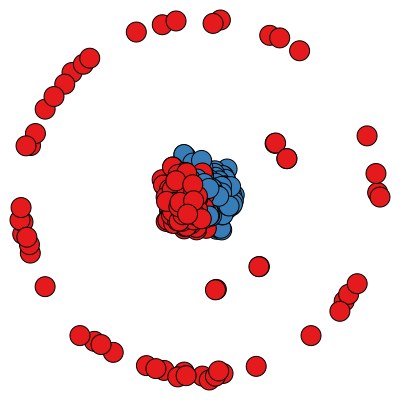

In [9]:
n=1000
q=2
nblocks=q
c=3.0
ep=.2
pin=c/(1.0+ep)/(n*1.0/q)
pout=c/(1+1.0/ep)/(n*1.0/q)
t=time()
prob_mat=np.identity(nblocks)*pin + (np.ones((nblocks,nblocks))-np.identity(nblocks))*pout

read=True
if read:
    RSBM=modbp.RandomSBMGraph(n,prob_mat,graph=ig.load('RSMB_test.graphml.gz'))
else:
    RSBM = modbp.RandomSBMGraph(n=n,comm_prob_mat=prob_mat)
    RSBM.graph.save('RSMB_test.graphml.gz')

color_dict=dict(zip(range(10),sbn.color_palette('Set1',10)))
# RSBM.graph.vs['color']=map(lambda x : color_dict[x],RSBM.graph.vs['block'])

elist=RSBM.get_edgelist()
elist.sort()
print elist[:5]

pv=modbp.bp.PairVector(elist)
bpgc=modbp.BP_Modularity(edgelist=pv, _n=n, q=q, beta=1.3, transform=False)
print 'niters to converge',bpgc.run(1000)
marg=np.array(bpgc.return_marginals())
print marg[:10]
part=np.argmax(marg,axis=1)
VC=ig.VertexClustering(RSBM.graph,membership=part)
# print "modularity: {:.6f}".format(mbpinterface.retrival_modularities[q][beta])
print "modularity igraph: {:.6f}".format(VC.modularity)
print "AMI: {:.3f}".format(RSBM.get_AMI_with_blocks(labels=part))
print "accuracy: {:.3f}".format(RSBM.get_accuracy(labels=part))
print "percent: {:.3f}".format(np.sum(RSBM.block==part)/(1.0*n))

RSBM.graph.vs['color']=map(lambda x : color_dict[x] ,np.argmax(marg,axis=1))
#create forceatlas layout
adj=np.array(RSBM.get_adjacency())
pos=fa2.forceatlas2(adj,scalingRatio=10,gravity=1,strongGravityMode=False,edgeWeightInfluence=0)
layout=ig.Layout(pos)
ig.plot(RSBM.graph,layout=layout,inline=True,bbox=[400,400])

# plot NMI as beta varies

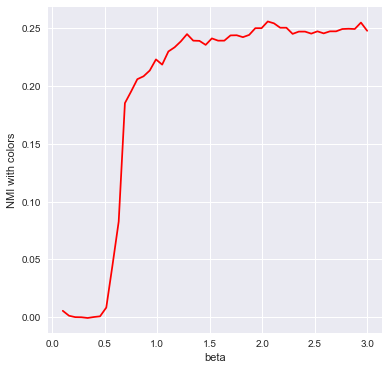

In [50]:
betas=np.linspace(.1,3,50)
fin_nmi=[]
for beta in betas:
    #This is where we would want to be able to recall the BP algorithm
    #without having to reconstruct the graph.  Presumably we could use 
    #the state of previous BP as warm initialization
    bpgc=modbp.BP_Modularity(edgelist=pv, _n=n, q=q, beta=beta, transform=False)
    bpgc.run()
    marg=np.array(bpgc.return_marginals())
    color_dict={0:"red",1:"blue",2:'green'}
    RSBM.graph.vs['color']=map(lambda x : color_dict[np.argmax(x)],marg)
    cnmi=RSBM.get_AMI_with_blocks(RSBM.graph.vs['color'])
#     print("NMI at beta={:.2f}: {:.3f}".format(beta,cnmi))
    fin_nmi.append(cnmi)

fin_nmi=np.array(fin_nmi)
plt.close()
f,a=plt.subplots(1,1,figsize=(6,6))
a.plot(betas,fin_nmi,color='r')
a.set_xlabel('beta')
a.set_ylabel('NMI with colors')
plt.show()

In [2]:
n = 1000
q = 2
nblocks = q
c = 3.0
ep = .1
pin = c / (1.0 + ep) / (n * 1.0 / q)
pout = c / (1 + 1.0 / ep) / (n * 1.0 / q)
prob_mat = np.identity(nblocks) * pin + (np.ones((nblocks, nblocks)) - np.identity(nblocks)) * pout
read = True
if read:
    print 'loading graph from file'
    RSBM = modbp.RandomSBMGraph(n, prob_mat, graph=ig.load('RSMB_test.graphml.gz'))
    print ("{:d},{:d}".format(RSBM.n,RSBM.m))
else:
    RSBM = modbp.RandomSBMGraph(n=n, comm_prob_mat=prob_mat,transform=False)
    RSBM.graph.save('RSMB_test.graphml.gz')

beta=1.5
#call directly
elist = RSBM.get_edgelist()
elist.sort()
pv = modbp.bp.PairVector(elist)
bpgc = modbp.BP_Modularity(edgelist=pv, _n=n, q=q, beta=beta, transform=False)
print ('niters to converge', bpgc.run(1000))
marg = np.array(bpgc.return_marginals())
print (marg[:5])
part=np.argmax(marg,axis=1)
print ("modularity: {:.4f} ".format(ig.VertexClustering(RSBM.graph,membership=part).modularity))
print ("AMI: {:.3f}".format(RSBM.get_AMI_with_blocks(labels=part)))
print ("accuracy: {:.3f}".format(np.sum(RSBM.block == part) / (1.0 * n)))

#test it with the calss method
mbpinterface = modbp.ModularityBP(RSBM.graph)  # create class
mbpinterface.run_modbp(beta,2,1000)
print mbpinterface.marginals[2][beta][:5]
print ('niters to converge',mbpinterface.niters[2][beta])
print ('modularity: {:.4f}'.format(mbpinterface.retrival_modularities[2][beta]))
print part[:20]
print mbpinterface.partitions[2][beta][:20]
print "AMI two partitions {:.3f}".format(skm.adjusted_mutual_info_score(part,mbpinterface.partitions[2][beta]))
# print 'AMI=',RSBM.get_AMI_with_blocks(mbpinterface.partitions[2][beta])
# print "accuracy=",RSBM.get_accuracy(mbpinterface.partitions[2][beta])

loading graph from file
1000,1502
('niters to converge', 30)
[[0.02786616 0.97213384]
 [0.05291597 0.94708403]
 [0.13891308 0.86108692]
 [0.80188059 0.19811941]
 [0.20623338 0.79376662]]
modularity: 0.4354 
AMI: 0.551
accuracy: 0.096
[[0.02786616 0.97213384]
 [0.05291597 0.94708403]
 [0.13891308 0.86108692]
 [0.80188059 0.19811941]
 [0.20623338 0.79376662]]
('niters to converge', 30)
modularity: 0.4354
[1 1 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
[1 1 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
AMI two partitions 0.867


# elist= randSBM.get_edgelist()
elist.sort()
print elist[:10]
print mbpinterface._edgelistpv

# hysteresis in modbp

In [2]:
n=1000
q=2
nblocks=q
c=3.0
ep=.2
pin=c/(1.0+ep)/(n*1.0/q)
pout=c/(1+1.0/ep)/(n*1.0/q)
prob_mat = np.identity(q) * pin + (np.ones((q, q)) - np.identity(q)) * pout
print prob_mat
randSBM=modbp.RandomSBMGraph(n,prob_mat)

mbpinterface=modbp.ModularityBP(randSBM.graph)
mbpinterface.run_modbp(q=2,beta=1.2)
mbpinterface.run_modbp(q=2,beta=.2)
mbpinterface.run_modbp(q=2,beta=.1)
mbpinterface.run_modbp(q=2,beta=.01)
print mbpinterface.retrival_modularities
print 
mbpinterface2=modbp.ModularityBP(randSBM.graph)
mbpinterface2.run_modbp(q=2,beta=.01)
mbpinterface2.run_modbp(q=2,beta=.1)
mbpinterface2.run_modbp(q=2,beta=.2)
mbpinterface2.run_modbp(q=2,beta=1.2)
print mbpinterface2.retrival_modularities


[[0.005 0.001]
 [0.001 0.005]]
{2: {0.01: 0.032831634073836845, 1.2: 0.30903585153264035, 0.1: 0.027631386581825516, 0.2: -0.007583358859935556}}

{2: {0.2: 0.0006420085490911082, 1.2: -0.0178363506937434, 0.1: -0.014715723574745352, 0.01: -0.027641829282725697}}


[[0.005 0.001]
 [0.001 0.005]]
average degree: 2.976


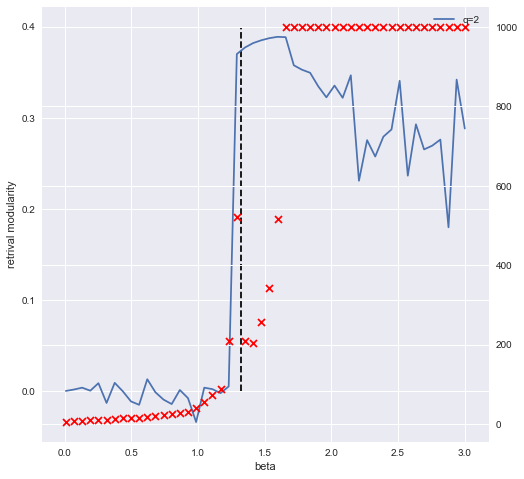

In [39]:
n=1000
q=2
nblocks=q
c=3
ep=.2
pin=c/(1.0+ep*(q-1.0))/(n*1.0/q)
pout=c/(1+(q-1.0)/ep)/(n*1.0/q)
prob_mat = np.identity(q) * pin + (np.ones((q, q)) - np.identity(q)) * pout
print prob_mat

randSBM=modbp.RandomSBMGraph(n,prob_mat)
mbpinterface=modbp.ModularityBP(randSBM.graph)

print("average degree: {:.3f}".format(2.0*mbpinterface.m/mbpinterface.n))
betas=np.linspace(.01,3,50)
# betas=np.array([.1,.5,1,1.2])
qs=np.array([2])#,4,5])

for q in qs:
    for beta in betas:
        mbpinterface.run_modbp(q=q,beta=beta,niter=1000)

plt.close()
f,a=plt.subplots(1,1,figsize=(8,8))

for q in qs:
    a.plot(mbpinterface.retrival_modularities.index.get_level_values(1),
           mbpinterface.retrival_modularities.loc[:,'retrival_modularity']
           ,label="q={:d}".format(q))
    a.vlines(x=mbpinterface.get_bstar(q),ymin=0,ymax=.4,linestyle='--')
    a2=a.twinx()
    b,t=zip(*sorted(mbpinterface.niters[q].items(),key=lambda x: x[0]))
    a2.scatter(b,t,marker='x',color='red',label='covergence')


a.set_xlabel("beta")
a.set_ylabel("retrival modularity")
a.legend()
plt.show()


In [37]:
mbpinterface.partitions[2]

[0.31510204081632653,
 2.1457142857142855,
 3.0,
 1.7185714285714286,
 1.2914285714285716,
 1.5355102040816326,
 0.8642857142857143,
 0.37612244897959185,
 2.633877551020408,
 2.206734693877551,
 1.96265306122449,
 0.1320408163265306,
 1.1083673469387756,
 0.01,
 0.986326530612245,
 0.43714285714285717,
 2.2677551020408164,
 1.779591836734694,
 1.3524489795918369,
 0.4981632653061225,
 2.7559183673469385,
 2.3287755102040815,
 0.6812244897959184,
 0.19306122448979593,
 1.5965306122448981,
 1.1693877551020408,
 0.8032653061224491,
 2.816938775510204,
 2.389795918367347,
 1.8406122448979594,
 1.4134693877551021,
 0.5591836734693878,
 2.5118367346938775,
 0.9253061224489797,
 2.8779591836734695,
 2.450816326530612,
 2.023673469387755,
 2.6948979591836735,
 1.6575510204081634,
 1.230408163265306,
 0.07102040816326531,
 2.572857142857143,
 0.6202040816326531,
 2.9389795918367345,
 0.2540816326530612,
 2.0846938775510204,
 1.9016326530612246,
 1.4744897959183674,
 1.0473469387755103,
 0.7422

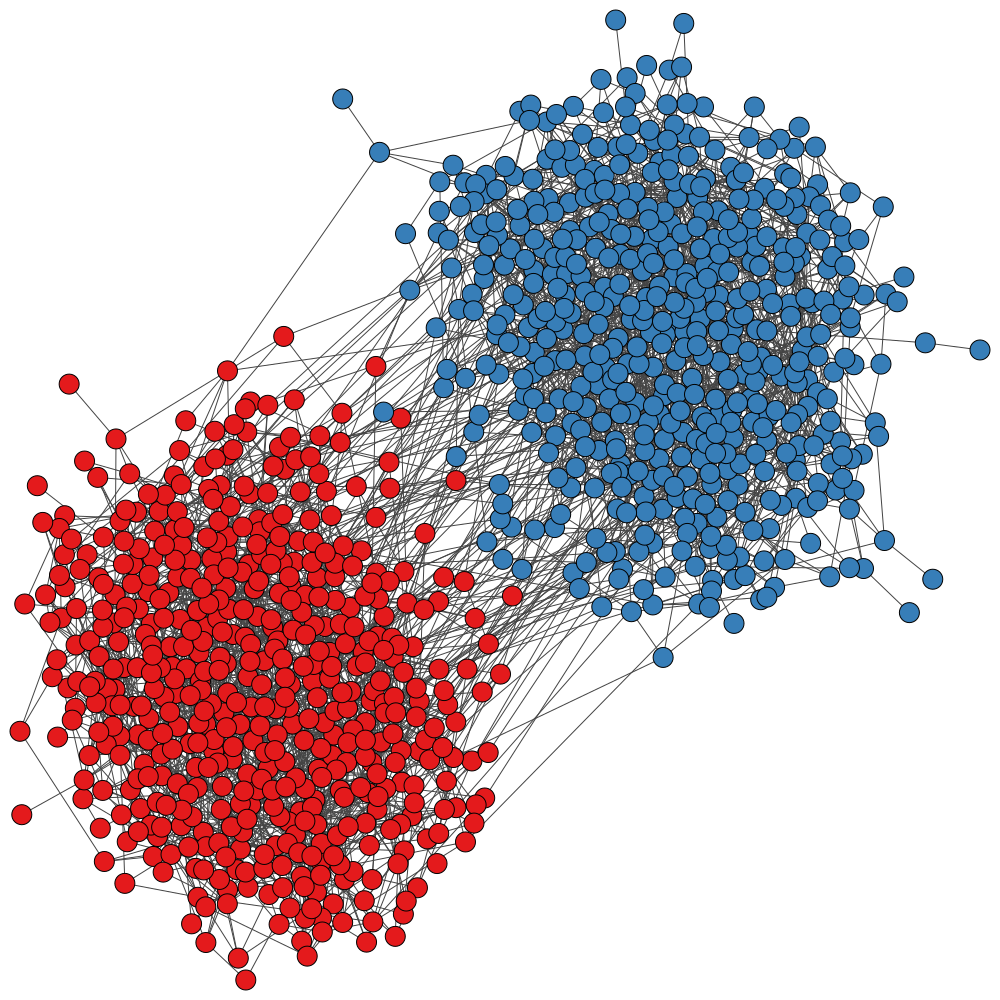

In [38]:
color_dict=dict(zip(range(10),sbn.color_palette('Set1',10)))
randSBM.graph.vs['color']=map(lambda x : color_dict[x] ,mbpinterface.partitions[2][0.986326530612245])
# randSBM.graph.vs['color']=map(lambda x : color_dict[x] ,randSBM.graph.vs['block'])

#create forceatlas layout
adj=np.array(randSBM.get_adjacency())
pos=fa2.forceatlas2(adj,scalingRatio=1000,gravity=.05,strongGravityMode=True,edgeWeightInfluence=0)
layout=ig.Layout(pos)
ig.plot(randSBM.graph,layout=layout,inline=True,bbox=[1000,1000])

In [22]:
randSBM.get_AMI_with_blocks(mbpinterface.partitions[2][1.5355102040816326])

0.27366695392661416

In [ ]:
b=np.array([0, 5, 2, 5, 4, 5])
c=[np.random.choice(np.flatnonzero(b == b.max())) for i in range(1000)]


[[0.0075  0.00075 0.00075 0.00075]
 [0.00075 0.0075  0.00075 0.00075]
 [0.00075 0.00075 0.0075  0.00075]
 [0.00075 0.00075 0.00075 0.0075 ]]
average degree: 2.378


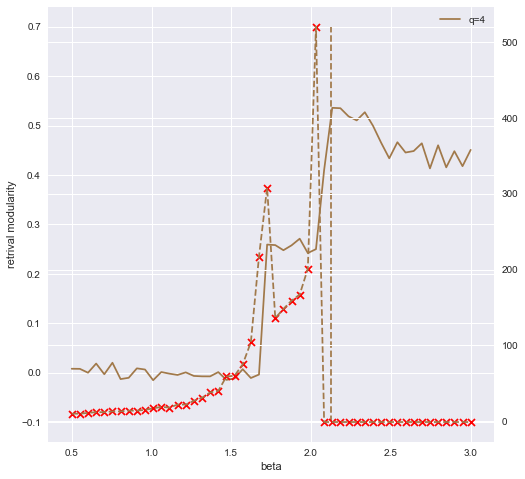

In [17]:
n=1000
q=4
nblocks=q
c=3.0
ep=.2
pin=c/(1.0+ep*(q-1.0))/(n*1.0/q)
pout=c/(1+(q-1.0)/ep)/(n*1.0/q)
prob_mat = np.identity(q) * pin + (np.ones((q, q)) - np.identity(q)) * pout
print (prob_mat)

outgraph="random_test-graph.graphml.gz"
read=False
if read:
    randSBM=modbp.RandomSBMGraph(n=n,comm_prob_mat=prob_mat,graph=ig.load(outgraph))
else:
    randSBM=modbp.RandomSBMGraph(n,prob_mat)
    randSBM.graph.save(outgraph)
mbpinterface=modbp.ModularityBP(randSBM.graph)

print("average degree: {:.3f}".format(2.0*mbpinterface.m/mbpinterface.n))
betas=np.linspace(.5,3,50)
# betas=np.array([.1,.5,1,1.2])
qs=np.array([4])#,4,5])
colors=sbn.color_palette('cubehelix',n_colors=len(qs))
for q in qs:
    for beta in betas:
        mbpinterface.run_modbp(q=q,beta=beta,niter=1000)

plt.close()
f,a=plt.subplots(1,1,figsize=(8,8))


for j,q in enumerate(qs):
    b,t=zip(*sorted(mbpinterface.niters[q].items(),key=lambda x: x[0]))
#     b,m=zip(*sorted(mbpinterface.retrival_modularities[q].items(),key=lambda x: x[0]))
    
    a.plot(mbpinterface.retrival_modularities.index.get_level_values(1),
           mbpinterface.retrival_modularities.loc[:,'retrival_modularity']
           ,label="q={:d}".format(q),c=colors[j])
    a.vlines(x=mbpinterface.get_bstar(q),ymin=-.1,ymax=.7,linestyle='--',color=colors[j])
    a2=a.twinx()
    a2.scatter(b,t,marker='x',color='red',label='covergence')
    a2.plot(b,t,linestyle='--',color=colors[j],label='covergence')


a.set_xlabel("beta")
a.set_ylabel("retrival modularity")
a.legend()
plt.show()


In [7]:
fbnet=ig.load("./football.net.graphml.gz")
bptest=modbp.ModularityBP(fbnet)
bptest.run_modbp(beta=1.1,q=5)
bptest.run_modbp(beta=1.2,q=2)
bptest.run_modbp(beta=1.6,q=2)
bptest.run_modbp(beta=1.6,q=2,resgamma=2.0)
bptest.run_modbp(beta=1.2,q=2,resgamma=2.0)

bptest.retrival_modularities.sort_index()

retrival_modularity
q beta resgamma                    
2 1.2  1.0                 0.346431
       2.0                -0.142053
  1.6  1.0                 0.345292
       2.0               -0.0997767
5 1.1  1.0                 0.569571

# Testing on football network
We scan to look at how many communities are suggested

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from time import time
import igraph as ig
import modbp
import forceatlas2 as fa2
import seaborn as sbn
import sklearn.metrics as skm
import pandas as pd
fbnet=ig.load("./football.net.graphml.gz")
mbpinter=modbp.ModularityBP(fbnet)

qs=np.arange(2,15)
# qs=np.array([7,8,9,10])
colors=sbn.cubehelix_palette(n_colors=len(qs))
gammas=np.linspace(.5,2,10)
# gammas=np.array([,1.1])

pd.DataFrame()
for gam in gammas:
    print(gam)
    for q in qs:
        bstar=mbpinter.get_bstar(q)
        betas=np.linspace(bstar-.25,bstar+.25,10)
#         betas=np.array([bstar])

#         betas=np.linspace(0,2.5,100)
        for beta in betas:
            mbpinter.run_modbp(q=q,beta=beta,resgamma=gam,niter=500)
    
    

0.5
0.6666666666666666
0.8333333333333333
1.0
1.1666666666666665
1.3333333333333333
1.5
1.6666666666666665
1.8333333333333333
2.0


In [5]:
import numpy as np
import matplotlib.pyplot as plt
from time import time
import igraph as ig
import modbp
import forceatlas2 as fa2
import seaborn as sbn
import sklearn.metrics as skm
import pandas as pd
fbnet=ig.load("./football.net.graphml.gz")
mbpinter=modbp.ModularityBP(fbnet)

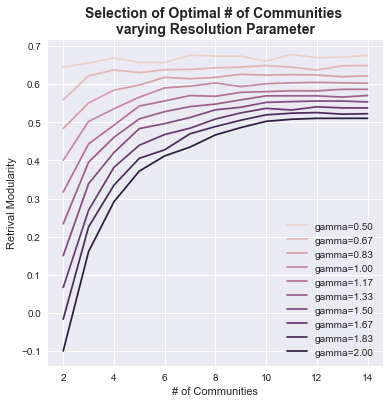

In [37]:
maxmods=mbpinter.retrival_modularities.groupby(level=(0,2)).apply(max).swaplevel(0,1)
maxmods.sort_index(inplace=True)
plt.close()
colors=sbn.cubehelix_palette(n_colors=len(maxmods.index.get_level_values(0).unique()))
f,a=plt.subplots(1,1,figsize=(6,6))
for i,gamma in  enumerate(maxmods.index.get_level_values(0).unique()):
    a.plot(maxmods.loc[gamma].index.values,
         maxmods.loc[gamma,'retrival_modularity'],color=colors[i],label='gamma={:.2f}'.format(gamma))
a.legend()
a.set_xlabel('# of Communities')
a.set_ylabel('Retrival Modularity')
a.set_title("Selection of Optimal # of Communities \nvarying Resolution Parameter",
           fontsize=14,fontweight='bold')
# a.set_xl
plt.show()



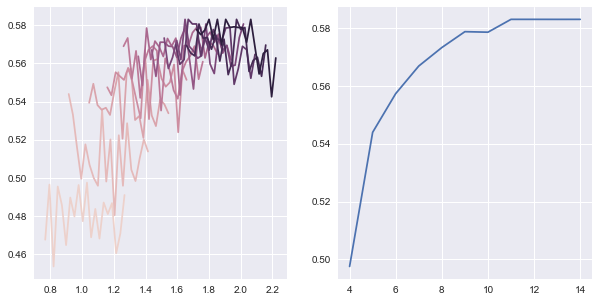

In [3]:
plt.close()
f,a=plt.subplots(1,2,figsize=(10,5))
a=plt.subplot(1,2,1)
for i,q in enumerate(qs):
    b,t=zip(*sorted(mbpinter.niters[q].items(),key=lambda x: x[0]))
    b,m=zip(*sorted(mbpinter.retrival_modularities[q].items(),key=lambda x: x[0]))
    a.plot(b,m,c=colors[i])
#     ax2=a.twinx()
#     ax2.plot(b,t,color=colors[i],linestyle='--')
a=plt.subplot(1,2,2)

q,mods=zip(*sorted( [ (q,np.max(mods.values())) for q,mods in mbpinter.retrival_modularities.items() ],
                key=lambda x : x[0]))
a.plot(q,mods)
plt.show()

# Test multilayer SBM

time to create 30 nodes and 3 layers : 0.00197


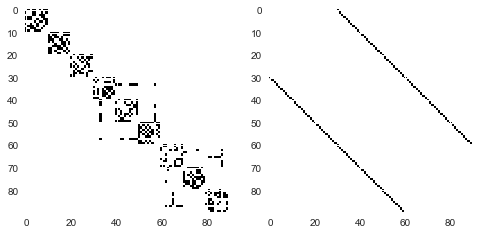

In [10]:
np.random.seed(1)
n = 30
nlayers=3
q = 3
nblocks = q
c = 5.0
ep = .001
pin = c / (1.0 + ep) / (n * 1.0 / q)
pout = c / (1 + 1.0 / ep) / (n * 1.0 / q)
prob_mat = np.identity(nblocks) * pin + (np.ones((nblocks, nblocks)) - np.identity(nblocks)) * pout
t=time()
ml_sbm=modbp.MultilayerSBM(n,comm_prob_mat=prob_mat,layers=nlayers,transition_prob=0)
print( "time to create {:d} nodes and {:d} layers : {:.5f}".format(n,nlayers,time()-t))



plt.close()
f,a=plt.subplots(1,2,figsize=(8,4))
a=plt.subplot(1,2,1)
plt.imshow(ml_sbm.get_intralayer_adj())
a=plt.subplot(1,2,2)
plt.imshow(ml_sbm.get_interlayer_adj())
plt.show()

In [10]:
x=np.array([1,2,3,4,5])
# x[[0,1,2]]+=1
inds,cnts=np.unique([0,0,0],return_counts=True)
x[inds]+=-1*cnts
print(x)

[-2  2  3  4  5]
